<img align="center" src="figures/course.png" width="800">

#                                    16720 (B) Bag of Visual Words - Assignment 2

     Instructor: Kris Kitani                   TAs: Sheng-Yu, Jinkun, Rawal, Arka, Rohan

In [2]:
import nbimporter
import numpy as np
import skimage
import multiprocess
import threading
import queue
import os,time
import math
from p1 import get_visual_words
from p2_1 import get_image_feature, distance_to_set

## For Autograding P3, ensure uploading `conf_matrix.npy`.

### Quantitative Evaluation

#### Calculating confusion matrix
Qualitative evaluation is all well and good (and very important for diagnosing performance gains and losses), but we want some hard numbers.

Load the corresponding test images and their labels, and compute the predicted labels of each, i.e., compute its distance to every image in training set and return the label with least distance difference as the predicted label. To quantify the accuracy, you will compute a confusion matrix $C$: given a classification problem, the entry $C(i,j)$ of a confusion matrix counts the number of instances of class $i$ that were predicted as class $j$. When things are going well, the elements on the diagonal of $C$ are large, and the off-diagonal elements are small. Since there are 8 classes, $C$ will be $8 \times 8$. The accuracy, or percent of correctly classified images, is given by the trace of $C$ divided by the sum of $C$.

#### Q3.1.1 (10 Points -> 5 Autograder + 5 WriteUp)
Implement the function
```
            def evaluate_recognition_system():
```
that tests the system and outputs the confusion matrix.

Report the confusion matrix and accuracy for your results in your write-up. This does not have to be formatted prettily: if you are using LaTeX, you can simply copy/paste it into a $verbatim$ environment. Additionally, do not worry if your accuracy is low: with 8 classes, chance is $12.5\%$. To give you a more sensible number, a reference implementation _with_ spatial pyramid matching gives an overall accuracy of around $50\%$.

Trained features shape:  (1000, 4200)
Predicted labels shape:  (160,)
My Confusion Matrix:


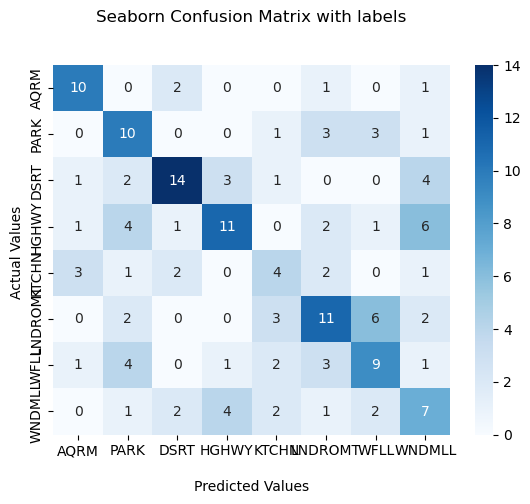

Accuracy: 0.475


In [3]:
def evaluate_recognition_system(num_workers=4):
    '''
    Evaluates the recognition system for all test images and returns the confusion matrix.

    [input]
    * num_workers: number of workers to process in parallel

    [output]
    * conf: numpy.ndarray of shape (8,8)
    * accuracy: accuracy of the evaluated system
    '''
    '''
    HINTS
    (1) You may wish to use multiprocessing to improve speed (NO Extra Points)
    (2) You may create helper function (in the same cell) to enable multiprocessing
    (3) Think Nearest Neighbor -> assign label using element closest in train set
    '''
    
    test_data = np.load("./data/test_data.npz")
    trained_system = np.load("trained_system.npz")
    
    image_names = test_data['files']
    image_names = ["./data/" + str(file) for file in image_names]
    test_labels = test_data['labels']

    trained_features = trained_system['features']
    train_labels = trained_system['labels']
    dictionary = trained_system['dictionary']
    SPM_layer_num = trained_system['SPM_layer_num']
    SPM_layer_num = int(SPM_layer_num)
    K = dictionary.shape[0]

    print("Trained features shape: ", trained_features.shape)
    
    # Gather arguments for multiprocessing
    args = []
    for idx, train_sample in enumerate(image_names):
        args.append((train_sample, dictionary, SPM_layer_num, K))

    # NxM array of the test features
    test_features = np.zeros((len(args), int(K / 3 * (4**(SPM_layer_num)-1))))

    # Debug for one process
    # feat = get_image_feature(image_names[0], dictionary, SPM_layer_num, K)
    # idx = np.argwhere(np.array(image_names) == feat[0])[0]
    # most_similar_idx = np.argmin(distance_to_set(feat[1], trained_features))
    # pred_labels[idx] = train_labels[most_similar_idx]

    # Dictionary to hold on to our predictions
    pred_labels_dict = {}

    # Multiprocess getting the image features
    with multiprocess.Pool(num_workers) as p:
        # Get the result
        result = p.starmap(get_image_feature, args)

        for r in result:  
            # For the test feature, find the nearest neighbor to the trained features
            # Take the argmax because we want the highest similarity
            most_similar_idx = np.argmax(distance_to_set(r[1], trained_features))

            # Find out the corresponding label that is the nearest neighbor
            pred_labels_dict[r[0]] = train_labels[most_similar_idx]

    pred_labels = np.array(list(pred_labels_dict.values()))
    print("Predicted labels shape: ", pred_labels.shape)
    
    # Look at sklearn confusion matrix to validate
    from sklearn.metrics import confusion_matrix
    sklearn_conf_matrix = confusion_matrix(test_labels, pred_labels)

    # Compute the confusion matrix
    num_labels  = len(np.unique(test_labels))
    conf_matrix = np.zeros((num_labels, num_labels))


    for i in range(len(test_labels)):
        conf_matrix[test_labels[i], pred_labels[i]] += 1

    # Calculate the accuracy
    accuracy = np.trace(conf_matrix) / len(image_names)

    # Visualize the confusion matrix
    def visualize_conf_matrix(conf_matrix):   
        import seaborn as sns
        import matplotlib.pyplot as plt
        labels = ["AQRM", "PARK", "DSRT", "HGHWY", "KTCHN", "LNDROMT", "WFLL", "WNDMLL"]
        ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues')
        ax.set_title('Seaborn Confusion Matrix with labels\n\n')
        ax.set_xlabel('\nPredicted Values')
        ax.set_ylabel('Actual Values ')
        ax.xaxis.set_ticklabels(labels)
        ax.yaxis.set_ticklabels(labels)
        plt.show()

    print("My Confusion Matrix:")
    visualize_conf_matrix(conf_matrix)
    # print("Sklearn Confusion Matrix")
    # visualize_conf_matrix(sklearn_conf_matrix)

    # Save confusion matrix to a file
    np.save("./conf_matrix.npy", conf_matrix)
    return conf_matrix, accuracy


# NOTE: comment out the lines below before submitting to gradescope
# conf_matrix, accuracy = evaluate_recognition_system()
# # We expect the accuracy to be greater than 0.45
# print("Accuracy:", accuracy)

<font color="blue">**Submit the Confusion Matrix and the Accuracy Value in the WriteUp**</font>

#### Q3.1.2 (5 points WriteUp):
<font color="blue"> As there are some classes/samples that are more difficult to classify than the rest using the bags-of-words approach, they are more easily classified incorrectly into other categories. **List some of these classes/samples and discuss why they are more difficult in your write-up.** </font>

### Q3.1.3 [Extra Credit](10 points) Manually Graded:

Now that you have seen how well your recognition system can perform on a set of real images, you can experiment with different ways of improving this baseline system. Here are a few suggestions:

* Hyperparameter Tuning: here is a list of hypterparameters in the system that you can tune to get better performance for your system:
        
        * `filter_scales`: a list of filter scales used in extracting filter response;
        * `K`: the number of visual words and also the size of the dictionary;
        * `alpha`: the number of sampled pixels in each image when creating the dictionary;
        * `L`: the number of spatial pyramid layers used in feature extraction.
        
* Image manipulation: Try using image augmentation techniques such as (1) random-crop, (2) flipping, (3) add noise, (4) jittering, etc. to obtain more training data for your system. You can also try resizing the images, subtracting the mean color, etc. 

* Better classifier: in part 2 we used the nearest neighbor classifier to classify test images. However, with our extracted SPM features from training images, we can use other classifiers such as multi-class logistic regression, multi-class support vector machine, etc. to gain better performance. For this, you can use implementation of these algorithms from `scipy`.


Tune the system you build to reach around 65\% accuracy on the provided test set (``data/test_data.npz``). <font color="blue">**In your writeup, document what you did to achieve such performance: (1) what you did, (2) what you expected would happen, and (3) what actually happened.** Also, include a file called ``custom.py/ipynb`` for running your code. </font>

### Q3.1.4 [Extra Credit] (25 points): Manually Graded
**GIST feature descriptor:** As introduced during the lecture, GIST feature descriptor is a feature extractor based on Gabor Filters. When we apply it to images, we have to implement the 2D Gabor Filters as described below

<img align="center" src="figures/gist.png" width="800">

In this part, please try to derive GIST features of images and study its effect to the performance of our built recognition system. The extra credits come from two parts:

* (10 points) Implement GIST feature extractor and visualize the features from the provided image `sun_aydaknxraiwghvmi.jpg`.
* (10 points) Try to incorporate the GIST features into the recognition system. You can feel free to tune the parameters and choose your classifier. Explain your observations and reasoning.

<font color="blue">**In your writeup (5 points): How does GIST descriptor affect the performance? Better or worse? Explain your reasoning?**
    

O: 0 S: 0
O: 0 S: 1
O: 0 S: 2
O: 0 S: 3
O: 1 S: 0
O: 1 S: 1
O: 1 S: 2
O: 1 S: 3
O: 2 S: 0
O: 2 S: 1
O: 2 S: 2
O: 2 S: 3
O: 3 S: 0
O: 3 S: 1
O: 3 S: 2
O: 3 S: 3
O: 4 S: 0
O: 4 S: 1
O: 4 S: 2
O: 4 S: 3
O: 5 S: 0
O: 5 S: 1
O: 5 S: 2
O: 5 S: 3
O: 6 S: 0
O: 6 S: 1
O: 6 S: 2
O: 6 S: 3
O: 7 S: 0
O: 7 S: 1
O: 7 S: 2
O: 7 S: 3


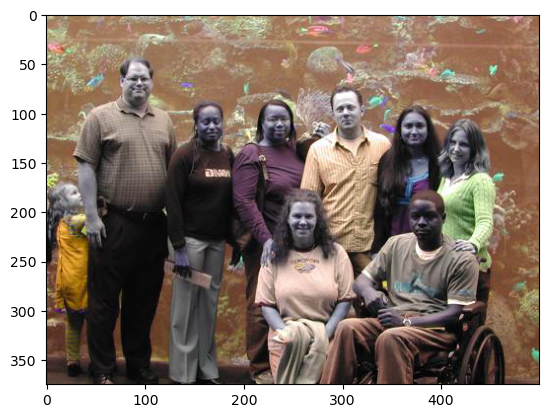

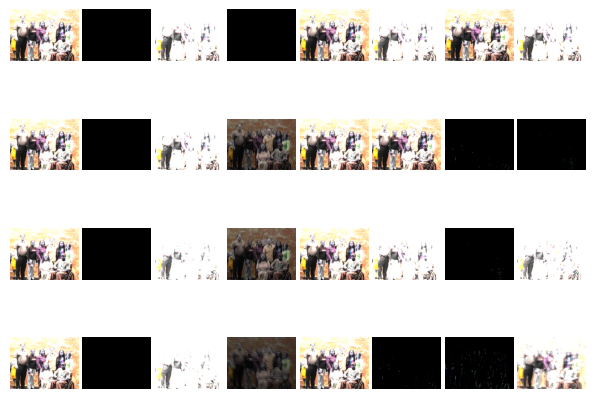

In [10]:
from distutils.command.build import build
import cv2
import matplotlib.pyplot as plt
from sklearn import svm

def compute_GIST(img, scales, orientations, sigma = 3, lambd = 1 * np.pi/4, gamma = 0.5, phi = 0):
    # Definte the size of the descriptor
    num_cells = 4
    cell_width  = img.shape[1] // num_cells
    cell_height = img.shape[0] // num_cells
    num_feature_maps = len(scales) * len(orientations)
    descriptor = np.zeros((4, 4, num_feature_maps))

    filter_bank = []
    for scale in scales:
        for orientation in orientations:
            filter_bank.append(cv2.getGaborKernel((scale, scale), sigma, orientation, lambd, gamma, phi))

    if len(img.shape) == 2:
        feature_maps = np.zeros((num_feature_maps, img.shape[0], img.shape[1], 1))
    if len(img.shape) == 3:
        feature_maps = np.zeros((num_feature_maps, img.shape[0], img.shape[1], img.shape[2]))

    # Compute the feature maps using all the filters will be size N x H x W
    for filter_num, filter in enumerate(filter_bank):
        feature_maps[filter_num] = cv2.filter2D(img, -1, filter)
    
    # Chunk the image into 4x4 cells and average the filter_responses over all the filters
    avg_cells = [np.average(feature_maps[:, i * cell_height : (i+1) * cell_height, j * cell_width : (j + 1) * cell_width], axis = (1, 2, 3)) for i in range(0, num_cells) for j in range(0, num_cells)]

    # Put the average response in the descriptor
    # We calculate the batches in row major order so lets store the descriptor that way too
    for cell_num, avg_cell in enumerate(avg_cells):
        descriptor[int(cell_num/ 4), (cell_num % 4)] = avg_cell

    # Output the descriptor of size 4x4xN (N is the size of the filter bank)
    return descriptor, feature_maps

def compute_GIST_wrapper(args):
    import nbimporter
    from p3 import compute_GIST
    idx, img, scales, orientations = args
    gist_descriptor = compute_GIST(img, scales, orientations)
    return idx, gist_descriptor

def visualize_gist_descriptor(gist_descriptor):
    """
    Visualize the GIST descriptor spatially
    """
    vis_img = np.average(gist_descriptor, axis=2)
    plt.imshow(vis_img)
    plt.colorbar()

def build_recognition_system_GIST(scales, orientations, num_workers=4):
    '''
    Creates a trained recognition system by generating training features from all training images.

    [input]
    * vgg16: prebuilt VGG-16 network.
    * num_workers: number of workers to process in parallel

    [saved]
    * features: numpy.ndarray of shape (N,K)
    * labels: numpy.ndarray of shape (N)
    '''

    train_data = np.load("./data/train_data.npz", allow_pickle=True)
    '''
    HINTS:
    1.> Similar approach as Q1.2.2 and Q3.1.1 (create an argument list and use multiprocessing)
    2.> Keep track of the order in which input is given to multiprocessing
    '''
    args = []

    # Parse out the training files
    train_files = train_data.get("files")
    if train_files is None:
        raise ValueError("No valid training files available :(")
    train_files = ["./data/" + str(file) for file in train_files]

    out  = np.zeros((len(train_files), len(scales)*len(orientations)*16))

    # Gather arguments for multiprocessing
    for idx, train_sample in enumerate(train_files):
        args.append((idx, skimage.io.imread(train_sample), scales, orientations))

    # Do the processing
    with multiprocess.Pool(num_workers) as p:
        # Run the function and save the result
        result = p.map(compute_GIST_wrapper, args)

        # Save the results in the dictionary
        for r in result:
            out[r[0]] = r[1].flatten()
        
    # Use the dictionary to get the ordered features
    # ordered_features = np.array(list(out.values()))
    '''
    HINTS:
    1.> reorder the features to their correct place as input
    '''
    print("done", out.shape)
    labels = train_data.get("labels")
    np.savez('trained_system_gist.npz', features=out, labels=labels)

def evaluate_recognition_system_GIST(num_workers=4):
    '''
    Evaluates the recognition system for all test images and returns the confusion matrix.

    [input]
    * num_workers: number of workers to process in parallel

    [output]
    * conf: numpy.ndarray of shape (8,8)
    * accuracy: accuracy of the evaluated system
    '''
    '''
    HINTS
    (1) You may wish to use multiprocessing to improve speed (NO Extra Points)
    (2) You may create helper function (in the same cell) to enable multiprocessing
    (3) Think Nearest Neighbor -> assign label using element closest in train set
    '''
    
    test_data = np.load("./data/test_data.npz")
    trained_system = np.load("trained_system_gist.npz")
    
    image_names = test_data['files']
    image_names = ["./data/" + str(file) for file in image_names]
    test_labels = test_data['labels']

    trained_features = trained_system['features']
    train_labels = trained_system['labels']

    print("Trained features shape: ", trained_features.shape)
    
    # Classifier
    clf = svm.SVC()
    clf.fit(trained_features, train_labels)

    # Gather arguments for multiprocessing
    args = []
    for idx, test_sample in enumerate(image_names):
        args.append((idx, skimage.io.imread(test_sample), scales, orientations))

    # Do the processing
    pred_labels = np.zeros(len(test_labels))
    with multiprocess.Pool(num_workers) as p:
        # Run the function and save the result
        result = p.map(compute_GIST_wrapper, args)

        # Save the results in the dictionary
        for r in result:
            feat = r[1].flatten()
            pred_labels[r[0]] = int(clf.predict(np.reshape(feat, (1, len(feat)))))

    print("Predicted labels shape: ", pred_labels.shape)
    num_labels = len(np.unique(test_labels))
    conf_matrix = np.zeros((num_labels, num_labels))
    print(test_labels.shape)
    print(pred_labels.shape)
    for i in range(len(test_labels)):
        conf_matrix[int(test_labels[i]), int(pred_labels[i])] += 1

    # Calculate the accuracy
    accuracy = np.trace(conf_matrix) / len(image_names)

    return accuracy, conf_matrix

# Visualize the confusion matrix
def visualize_conf_matrix(conf_matrix):   
    import seaborn as sns
    import matplotlib.pyplot as plt
    labels = ["AQRM", "PARK", "DSRT", "HGHWY", "KTCHN", "LNDROMT", "WFLL", "WNDMLL"]
    ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues')
    ax.set_title('Seaborn Confusion Matrix with labels\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.show()

# Load the image of interest
img = cv2.imread("./data/aquarium/sun_aydaknxraiwghvmi.jpg")

# 4 scales, 8 orientations
num_orientations = 8
num_scales       = 4
orientations = np.arange(0, np.pi, np.pi/num_orientations)
scales       = np.arange(3, 3 + 2 * num_scales, 2)

# Create the descriptor
gist_descriptor, feat_maps = compute_GIST(img, scales, orientations)
plt.figure(1)
plt.imshow(img)
plt.figure(2)
idx = 0
for o in range(num_orientations):
    for s in range(num_scales):
        idx+=1
        plt.subplot(num_scales, num_orientations,idx)
        print(f"O: {o} S: {s}")
        plt.imshow(feat_maps[o*s + s].astype("int"))
        plt.axis("off")

plt.subplots_adjust(left=0.05,right=0.95,top=0.95,bottom=0.05,wspace=0.05,hspace=0.05)
plt.show()

# Visualize it

# visualize_gist_descriptor(gist_descriptor)

# # Build the recoginition system, evaluate it, then show the metrics
# build_recognition_system_GIST(scales, orientations)
# accuracy, conf_mtx = evaluate_recognition_system_GIST()
# print(f"Accuracy: {accuracy}")
# plt.figure(2)
# visualize_conf_matrix(conf_mtx)